In [1]:
!pip install bigartm
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 52.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=4d9718dd18cfd65e945375fb2a6b221a3285db875627317365b081f20e7af47c
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [2]:
import re
from tqdm.notebook import tqdm
import artm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from pymorphy2 import MorphAnalyzer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [6]:
from google.colab import files
uploaded = files.upload()

Saving rospotrebnadzor.csv to rospotrebnadzor.csv


In [19]:
import pandas as pd
import io

data = pd.read_csv(io.BytesIO(uploaded['rospotrebnadzor.csv']))
data.head(10)

,Unnamed: 0,questions,answers
0,0,Помогите пожалуйста в расторжении договора с П...,Уважаемый Игорь!\r\nВ соответствии с пунктом 4...
1,1,"Жалоба на детскую поликлинику номер 15, по адр...","Ксения!\r\n Вопросы, поставленные в Ва..."
2,2,Я врач-инфекционист хочу открыть инфекционный ...,"Здравствуйте, Елена! При осуществлении медицин..."
3,3,"Возле подъезда лежат мертвые птицы, УК Наш Гор...","Ольга,добрый день! В Московской области с таки..."
4,4,Прошу провести проверку по факту размещения ра...,"Вячеслав,добрый день! Вам необходимо перенапра..."
5,5,Здравствуйте! Я отправила своего ребёнка 2009 ...,"Ольга,добрый день! Вам необходимо перенаправит..."
6,6,Текст заявления в прикрепленной файле,Стебликовой Марии Юрьевне\r\n Управление Рос...
7,7,"11.08.2022г. неустановленное лицо, путем обман...",No answer
8,8,15.08.22 мною была совершена покупка на сумму ...,"Ольга,добрый день! Управление Роспотребнадзора..."
9,9,При получении товара в пункте выдачи заказов О...,Правоотношения между данным интернет - магазин...


In [20]:
print(len(data))
data.drop('Unnamed: 0', axis=1, inplace=True)
data = data[data['answers'] != 'No answer']
data = data[~data.duplicated()]
print(len(data))
data.head()

2995
2930


,questions,answers
0,Помогите пожалуйста в расторжении договора с П...,Уважаемый Игорь!\r\nВ соответствии с пунктом 4...
1,"Жалоба на детскую поликлинику номер 15, по адр...","Ксения!\r\n Вопросы, поставленные в Ва..."
2,Я врач-инфекционист хочу открыть инфекционный ...,"Здравствуйте, Елена! При осуществлении медицин..."
3,"Возле подъезда лежат мертвые птицы, УК Наш Гор...","Ольга,добрый день! В Московской области с таки..."
4,Прошу провести проверку по факту размещения ра...,"Вячеслав,добрый день! Вам необходимо перенапра..."


In [22]:
morpher = MorphAnalyzer()
sw = set(stopwords.words('russian'))

def convert_to_vw_format(index, text):
    return f'doc{index} {text} |XXX'

def preprocess_text(index, text):
    text = text.lower()
    text = re.sub(r"\W", ' ', text)
    words = text.split()
    words = [word for word in words if word not in sw]
    words = list(map(str.strip, words))
    words = [word for word in words if len(word) > 2]
    words = [morpher.parse(word)[0].normal_form for word in words]
    return convert_to_vw_format(index, ' '.join(words))

with open('rospotrebnadzor.wv', 'w') as f:
    for index, text in tqdm(enumerate(data['questions']), total=len(data['questions'])):
      f.write(preprocess_text(index, text))
      f.write('\n')


  0%|          | 0/2930 [00:00<?, ?it/s]

In [23]:
batch_vectorizer = artm.BatchVectorizer(data_path='rospotrebnadzor.wv',
                                        data_format='vowpal_wabbit',
                                        target_folder='rospotrebnadzor_batches')

batch_vectorizer.dictionary.filter(min_tf=50, max_tf=3000)

artm.Dictionary(name=5a8107d3-5b86-4c36-a319-8768a4ea9208, num_entries=732)

  0%|          | 0/6 [00:00<?, ?it/s]

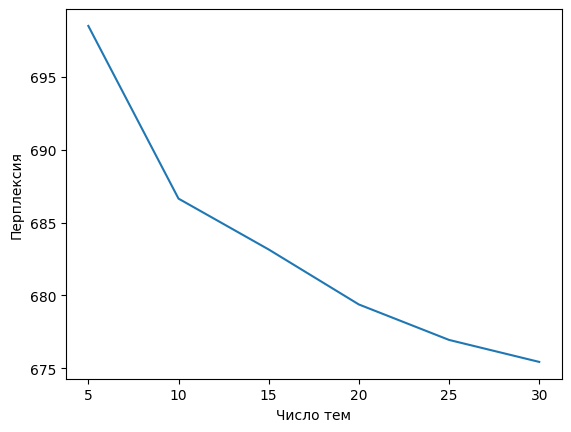

CPU times: user 1.83 s, sys: 142 ms, total: 1.97 s
Wall time: 1.35 s


In [24]:
%%time
topics_list = [5, 10, 15, 20, 25, 30]
perplexity = []

for num in tqdm(topics_list, total=len(topics_list)):
    plsa = artm.ARTM(num_topics=num, dictionary=batch_vectorizer.dictionary)
    plsa.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=batch_vectorizer.dictionary))
    plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
    plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
    perplexity.append(plsa.score_tracker['perplexity_score'].value[-1])

plt.plot(topics_list, perplexity)
plt.xlabel('Число тем')
plt.ylabel('Перплексия')
plt.show()

  0%|          | 0/10 [00:00<?, ?it/s]

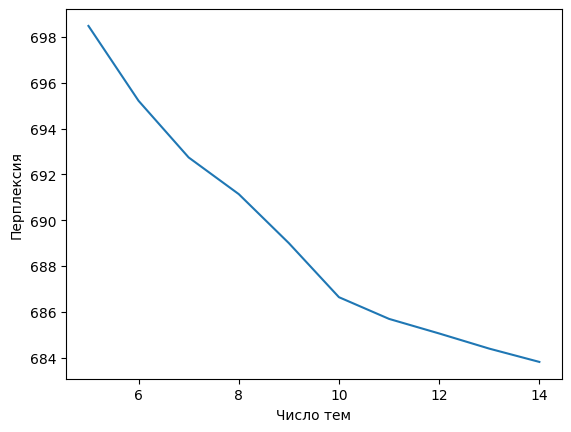

CPU times: user 2.57 s, sys: 174 ms, total: 2.74 s
Wall time: 1.87 s


In [25]:
%%time
perplexity = []

for num in tqdm(range(5, 15), total=10):
    plsa = artm.ARTM(num_topics=num, dictionary=batch_vectorizer.dictionary)
    plsa.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=batch_vectorizer.dictionary))
    plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
    plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=1)
    perplexity.append(plsa.score_tracker['perplexity_score'].value[-1])

plt.plot(range(5, 15), perplexity)
plt.xlabel('Число тем')
plt.ylabel('Перплексия')
plt.show()

In [26]:
plsa = artm.ARTM(num_topics=10, dictionary=batch_vectorizer.dictionary)
plsa.scores.add(artm.PerplexityScore(name='perplexity_score', dictionary=batch_vectorizer.dictionary))
plsa.scores.add(artm.TopTokensScore(name='TopTokensScore', num_tokens=6))
plsa.fit_offline(batch_vectorizer=batch_vectorizer, num_collection_passes=10)

In [27]:
for topic_name in plsa.topic_names:
    print (topic_name + ': ', plsa.score_tracker['TopTokensScore'].last_tokens[topic_name])

topic_0:  ['договор', 'право', 'потребитель', 'информация', 'продажа', 'защита']
topic_1:  ['дом', 'адрес', 'наш', 'квартира', 'вода', 'просить']
topic_2:  ['день', 'добрый', 'сказать', 'ребёнок', 'делать', 'здравствуйте']
topic_3:  ['средство', 'возврат', 'денежный', 'билет', '2022', 'ооо']
topic_4:  ['магазин', 'товар', 'продавец', 'возврат', 'вернуть', 'день']
topic_5:  ['это', 'услуга', 'цена', 'сайт', 'который', 'один']
topic_6:  ['карта', 'номер', 'сумма', 'банк', 'мой', 'счёт']
topic_7:  ['заказ', 'товар', 'доставка', '2022', 'день', 'интернет']
topic_8:  ['просить', 'проверка', 'область', 'который', 'площадка', 'санитарный']
topic_9:  ['деньга', 'телефон', 'ремонт', 'год', 'центр', 'заявка']


Интерпритация тем:
0. Недвижимость
1. ЖКХ
2. Дети
3. Финансы и бизнес
4. Торговля и качество товаров
5. Оказание услуг
6. Банковские услуги
7. Интернет торговля
8. Санитария
9. Ремонт техники



